Let's consider the problem of fitting some data points to a straight line model
\begin{equation}
y = m x + b
\end{equation}
Using Python, we have SO MANY ways of doing this fit and getting errors on the derived slope and intercept. 

Recall that from our theoretical discussion of linear fitting, we expect the error to be related to the covariance matrix, and that matrix depends on both the model that we are fitting $X$, and the inverse of covariance of the data points, $W = C^{-1}_{data}$, with the covariance matrix for the parameters given by
\begin{equation}
C_{parameters} = (X^T W X)^{-1}
\end{equation}

*All of the different methods for getting parameter errors in Python have slightly different ways of supplying information about $W$ and requesting the above version of $C_{parameters}$.*

0) Since this is a linear model, we have the analytical formula using matrix operations.  Here we calculate the covariance matrix ourselves, using a $W$ we supply.

1) `numpy.polyfit`.  To get the covariance we want we have to use a keyword: `cov='unscaled'` and `w=1/sigma` where `sigma` is the standard deviation associated with each data point.

2) `scipy.optimize.curve_fit`.  `curve_fit` requires `absolute_sigma=True` and `sigma=sigma` where `sigma` is the standard deviation associated with each data point.

3) `astropy.modeling`.  To get `astropy` to return a covariance matrix for the parameters, we need to use `fit = fitting.LevMarLSQFitter()` (Levenberg-Marquardt least-squares algorithm) and not `fitting.LinearLSQFitter`.  We also need to need to do the fit with `fit( ...., weights = 1/sigma)` and then look at the matrix `fit.fit_info['cov_x']`.

They all give the same answer, and the same (analytical) covariance.  Let's look at that in practice.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import scipy.stats as stats
from scipy.optimize import curve_fit

In [2]:
# A useful function for histograms
def BinCenter(edge):
    centers = (edge[1:]+edge[0:-1])/2.
    return centers

# Define the noise standard deviation

The number we use to define the standard deviation of the random noise is important for getting the right covariance matrix from the various fitters

In [3]:
# I want to pick a number different from 1 so that its effects are apparent
sigma_noise = 1.5 

In [4]:
# define a model for a line (uses astropy models, but not the fitting functions)
m0 = 1.0
b0 = 0.0
line_orig = models.Linear1D(slope=m0, intercept=b0)

# An important part of this model is the range of x, which will affect the covariance as well
x_min = 0.0
x_max = 10.0

# generate x, y data non-uniformly spaced in x
# add noise to y measurements
npts = 30

x = np.random.uniform(x_min, x_max, npts)
y = line_orig(x)
yunc = np.random.normal(0.0, sigma_noise, npts)
y += yunc

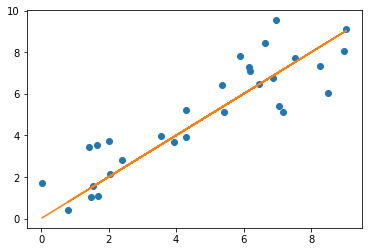

In [5]:
plt.plot(x, y, 'o')
plt.plot(x, line_orig(x))
plt.show()

Below we're going to define a linear fit according to the linear least squares mathematics, with the weight matrix $W$ assumed to be the identity (`np.eye`, get it?) if none is provided.  Note that `np.matmul` is matrix multiplication in the usual way, so
\begin{equation}
X^T W X
\end{equation}
for example, is written as `np.matmul(X.T, np.matmul(W, X))`.  That is, first multiply $W X$ (order matters!) and then multiply $X^T$ on that product.

In [6]:
def LinearFit(x, y, W = None):
    
    if W is None:
        W = np.eye(len(x))
        
    # Make the matrix X.  
    # A constant vector, and a vector proportional to the independent variable x
    X = np.array([ [x], [np.ones_like(x)]]).squeeze().T
    Cinv = np.matmul(X.T, np.matmul(W, X))
    C = np.linalg.inv(Cinv)
    params = np.matmul(C, np.matmul(X.T, np.matmul(W, y)))
    return params, C

In [7]:
inverse_var_weights = np.ones_like(x)/sigma_noise**2
inverse_std_weights = np.ones_like(x)/sigma_noise
Wmatrix = np.diag(inverse_var_weights)

Notice that we get different answers for the *covariance* if we do or do not include the actual known variance of the random errors.  Note that the fitted parameters do *not* depend on the actual size of the errors.  This is a feature of *linear fitting* with errors that are proportional to the identity matrix.  You can notice that in a such a case, the size of the errors cancels in the equation for the parameters.  This is *not* a general feature of nonlinear fitting or non-uniform errors.

In [8]:
params, C = LinearFit(x, y)
print('Parameters')
print(params)
print('Covariance')
print(C)

Parameters
[0.85222093 0.98873175]
Covariance
[[ 0.00464463 -0.02222237]
 [-0.02222237  0.13965703]]


In [9]:
params, C = LinearFit(x, y, W = Wmatrix)
print('Parameters')
print(params)
print('Covariance')
print(C)

Parameters
[0.85222093 0.98873175]
Covariance
[[ 0.01045041 -0.05000034]
 [-0.05000034  0.31422831]]


In [10]:
# Polyfit
p, cov = np.polyfit(x, y, 1, w=inverse_std_weights, cov='unscaled')
print('Parameters')
print(p)
print('Covariance')
print(cov)

Parameters
[0.85222093 0.98873175]
Covariance
[[ 0.01045041 -0.05000034]
 [-0.05000034  0.31422831]]


In [11]:
def Line(x, m, b):
    return m * x + b

params, params_covariance = curve_fit(Line, x, y, p0=[1, 0], 
                                      absolute_sigma=True, sigma=1./inverse_std_weights)
print('Parameters')
print(params)
print('Covariance')
print(params_covariance)

Parameters
[0.85222094 0.98873174]
Covariance
[[ 0.01045041 -0.05000034]
 [-0.05000034  0.31422831]]


The tutorial page for using the `astropy` fitting functions:

https://docs.astropy.org/en/stable/modeling/example-fitting-line.html

In [12]:
# The astropy method
# initialize a linear fitter
#fit = fitting.LinearLSQFitter() # for some reason, this does not compute a covariance matrix
fit = fitting.LevMarLSQFitter()

# initialize a linear model
line_init = models.Linear1D(slope=m0, intercept=b0)

# fit the data with the fitter
fitted_line = fit(line_init, x, y, weights = inverse_std_weights)

print(fitted_line)
print(fit.fit_info['cov_x'])

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept     
    ------------------ ------------------
    0.8522209342419147 0.9887317499497267
[[ 0.01045041 -0.05000034]
 [-0.05000034  0.31422831]]


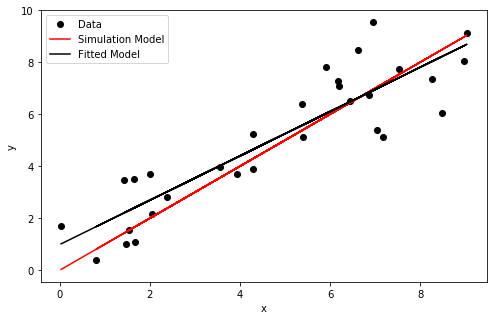

In [13]:
# plot
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko', label='Data')
plt.plot(x, line_orig(x), 'r-', label='Simulation Model')
plt.plot(x, fitted_line(x), 'k-', label='Fitted Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [14]:
%%time
# Create many realizations of the random errors (sometimes termed "noise").
Nrlz = 10000

# Save all the results 
slopes = np.zeros(Nrlz) 
intercepts = np.zeros(Nrlz)
covariances = np.zeros([Nrlz,2,2])
for i in np.arange(Nrlz):
    # Generate the random x, y positions, values and errors
    x = np.random.uniform(x_min, x_max, npts)
    y = line_orig(x) + np.random.normal(0.0, sigma_noise, npts)
    
    # fit the data with the astropy fitter ... they're all the same
    fitted_line = fit(line_init, x, y, weights = inverse_std_weights)
    # save the result
    slopes[i] = fitted_line.slope.value
    intercepts[i] = fitted_line.intercept.value
    covariances[i,:,:] = fit.fit_info['cov_x']

CPU times: user 17.8 s, sys: 18.6 ms, total: 17.8 s
Wall time: 17.8 s


We can make a covariance between the results from fitting the simulations, which I'll call ``empirical''.

In [15]:
empirical_data = (np.array([[slopes], [intercepts]])).squeeze()
empirical_covariance = np.cov(empirical_data)
empirical_correlation = np.corrcoef(empirical_data)

We also have a different computed covariance from each fit, and they are slightly different because we changed the spacing of the x values.  So we have a list that's [Nrlz, 2, 2], so we are literally going to average the matrices over all Nrlz different versions, which we do with the `numpy` command below:

In [16]:
analytic_covariance = covariances.mean(axis=0)

In [17]:
print('Empirical Covariance')
print(empirical_covariance)
print('Average of Analytic Covariance')
print(analytic_covariance)

Empirical Covariance
[[ 0.0095371  -0.04765049]
 [-0.04765049  0.31638574]]
Average of Analytic Covariance
[[ 0.00960636 -0.04803041]
 [-0.04803041  0.31797382]]


Let's also look at the fitted values from our simulations to show the distribution of the fitted slopes and intercepts.

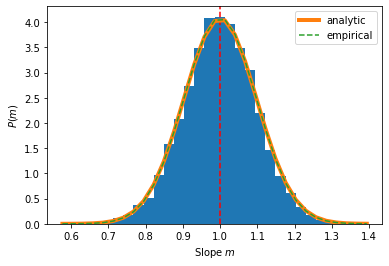

In [18]:
m_hist, m_bins, patches = plt.hist(slopes, bins=30, density=True)
plt.axvline(m0, color='red', linestyle='--')
plt.plot(m_bins, stats.norm.pdf(m_bins, loc=m0, scale=np.sqrt(analytic_covariance[0,0])), 
         label='analytic',linewidth=4)
plt.plot(m_bins, stats.norm.pdf(m_bins, loc=m0, scale=np.sqrt(empirical_covariance[0,0])), 
         label='empirical', linestyle='--')
plt.legend()
plt.xlabel(r'Slope $m$')
plt.ylabel(r'$P(m)$')
plt.show()

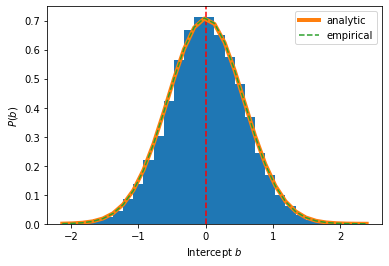

In [19]:
b_hist, b_bins, patches = plt.hist(intercepts, bins=30, density=True)
plt.axvline(b0, color='red', linestyle='--')
plt.plot(b_bins, stats.norm.pdf(b_bins, loc=b0, scale=np.sqrt(analytic_covariance[1,1])), 
         label='analytic',linewidth=4)
plt.plot(b_bins, stats.norm.pdf(b_bins, loc=b0, scale=np.sqrt(empirical_covariance[1,1])), 
         label='empirical', linestyle='--')
plt.legend()
plt.xlabel(r'Intercept $b$')
plt.ylabel(r'$P(b)$')
plt.show()

We can visualize the simulated *variances* as these histograms, but how should we think about the *covariance*?  Well, we can certainly histogram the off-diagonal values that would go into the sum that `np.cov` is computing, namely 
\begin{equation}
c_i = (b_i - \bar{b})(m_i - \bar{m})
\end{equation}
This is particularly simple because we only have two parameters.

Keep in mind, though, that this is a different kind of plot from above, because above the mean is parameter value and variance is what is in the covariance matrix.  For the plot below, the *average* is the measured covariance, and the variance of the histogram is not something we typically look at.

Mean of distribution -0.04764572265781294


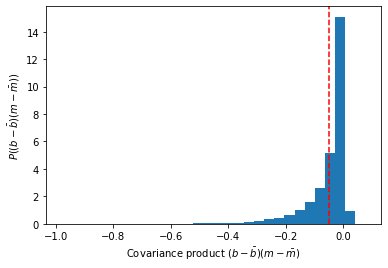

In [20]:
partial_cov = (intercepts - intercepts.mean())*(slopes - slopes.mean())
print('Mean of distribution', partial_cov.mean())
cov_hist, cov_bins, patches = plt.hist(partial_cov, bins=30, density=True)
plt.axvline(analytic_covariance[0,1], color='red', linestyle='--')
#plt.plot(b_bins, stats.norm.pdf(b_bins, loc=0., scale=np.sqrt(np.abs(analytic_covariance[0,1])))
plt.xlabel(r'Covariance product $(b-\bar{b})(m-\bar{m})$')
plt.ylabel(r'$P((b-\bar{b})(m-\bar{m}))$')
plt.show()

Probably a better way to think about the covariance between the two parameters is to think about the joint probability function.  One to start thinkgin about is just to make a scatter plot of intercept vs. slope to see how the two values are related to each other.

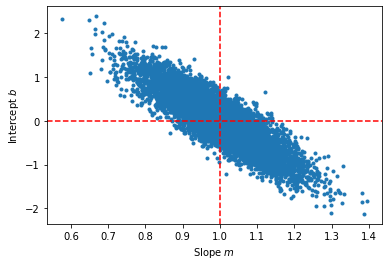

In [21]:
plt.plot(slopes, intercepts, '.')
plt.axvline(m0, color='red', linestyle='--')
plt.axhline(b0, color='red', linestyle='--')
plt.ylabel(r'Intercept $b$')
plt.xlabel(r'Slope $m$')
plt.show()

We can thinking of the density of points in a region as measurig the *joint probability* of measuring a given $m$ and $b$.  One thing we can notice is that the probabilities are *correlated* (actually, anti-correlated).  We can see this because if my value of $b<b_0$, my value of $m$ is far more likely to be $m>m_0$ (and vice versa) whereas if the variables were uncorrelated, there would be an equal chance of finding a value of $m < m_0$.  This manifests as a *slope* in the orientation of the ellipse above.  

In [22]:
empirical_correlation

array([[ 1.        , -0.86746249],
       [-0.86746249,  1.        ]])

The correlation matrix $R$ above is defined as
\begin{equation}
R_{ij} = \frac{C_{ij}}{\sigma_i \sigma_j}
\end{equation}
where $C_{ij}$ is the covariance matrix and 
\begin{equation}
\sigma^2_i \equiv C_{ii}
\end{equation} 
We show below how to calculate this using `numpy` tricks:

In [23]:
# Take the diagonal elements of the covariance and take their square root
norm = np.sqrt(np.diag(empirical_covariance))
# Use the outer product to compute all the sigma_i sigma_j pairs
norm_outer = np.outer(norm, norm)
# Then do an element-by-element division
print(empirical_covariance/norm_outer)

[[ 1.         -0.86746249]
 [-0.86746249  1.        ]]


This way of writing things makes it much more apparent that errors on the slope and intercept are highly correlated.  (What would the correlation matrix look like for uncorrelated errors?)

The scatter plot clearly shows the slope of the ellipse, which is related to this (anti)-correlation.  One disadvantage of that plot, though, is that its hard to tell how much more likely any given position in the $(m,b)$ plane is.  It would be good to be able to actually plot the density of points as a contour plot or an intensity image.  To do this, we need to effectively create a 2-D histogram.  We can also add a contour plot on top of the histogram.

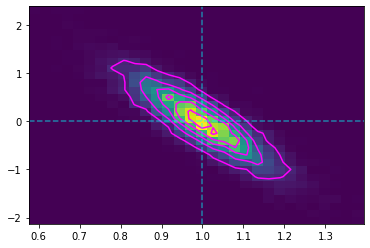

In [24]:
# Getting the axis labels to line up with the contours seems tricky, and I'm not sure I've done it correctly here
import scipy.ndimage
h_mb, x_mb, y_mb, _ = plt.hist2d(slopes, intercepts, bins=30, density=True)
plt.contour(BinCenter(x_mb), BinCenter(y_mb), h_mb.T, colors='magenta', levels=np.linspace(0.1,0.9,num=5)*h_mb.max())
plt.axvline(m0, color='cyan', linestyle='--', alpha=0.5)
plt.axhline(b0, color='cyan', linestyle='--', alpha=0.5)

A nice package for displaying this is `seaborn`, which implements a *kernel density estimator*, a kind of smoothed version of the 2D histogram.

In [25]:
import seaborn as sns

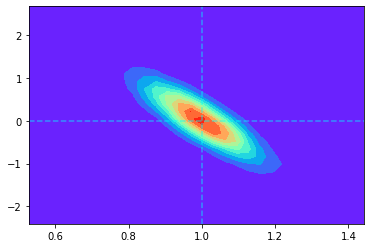

In [26]:
sns.kdeplot(slopes, intercepts, shade=True, gridsize=30, cmap='rainbow')
plt.axvline(m0, color='cyan', linestyle='--', alpha=0.5)
plt.axhline(b0, color='cyan', linestyle='--', alpha=0.5)
plt.show()